# Исследование данных об аренде самокатов

#### Шаг 1. Загрузка данных

**Создадим новые функции для работы**

In [1]:
# функция вывода информации о датасете
def dataset_info(dataset):
    print(dataset.info())
    print(dataset.describe())
    display(dataset.head())

##### Начнем работу с датасетами

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt, factorial

In [3]:
pd.set_option('display.max_columns', None) #установим опцию по выводу всех колонок датафрейма

#укажем формат отображения больших чисел,
pd.set_option('display.float_format', '{:.2f}'.format) #чтобы не применялась экспоненциальная запись в таблицах

In [4]:
users = pd.read_csv('./users_go.csv')
rides = pd.read_csv('./rides_go.csv')
subscriptions = pd.read_csv('./subscriptions_go.csv')

##### Изучим общую информацию о каждом датафрейме

In [5]:
dataset_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
       user_id     age
count  1565.00 1565.00
mean    762.63   24.92
std     443.26    4.55
min       1.00   12.00
25%     378.00   22.00
50%     762.00   25.00
75%    1146.00   28.00
max    1534.00   43.00


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [6]:
dataset_info(rides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
       user_id  distance  duration
count 18068.00  18068.00  18068.00
mean    842.87   3070.66     17.81
std     434.73   1116.83      6.09
min       1.00      0.86      0.50
25%     487.00   2543.23     13.60
50%     889.00   3133.61     17.68
75%    1213.25   3776.22     21.72
max    1534.00   7211.01     40.82


,user_id,distance,duration,date
0,1,4409.92,25.60,2021-01-01
1,1,2617.59,15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,2694.78,18.51,2021-08-11
4,1,4028.69,26.27,2021-08-28


In [7]:
dataset_info(subscriptions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None
       minute_price  start_ride_price  subscription_fee
count          2.00              2.00              2.00
mean           7.00             25.00             99.50
std            1.41             35.36            140.71
min            6.00              0.00              0.00
25%            6.50             12.50             49.75
50%            7.00             25.00             99.50
75%            7.50             37.50            149.25
max            8.00             50.00            199.00


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:** В данных отсутствуют пропуски. В датафрейме ```rides``` столбец ```date``` имеет тип ```object```, нужно привести его к типу ```datetime```.

#### Шаг 2. Предобработка данных

##### Приведём столбец ```date``` к типу даты

In [8]:
rides['date'] = pd.to_datetime(rides['date'])

#проверим результат
dataset_info(rides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB
None
       user_id  distance  duration
count 18068.00  18068.00  18068.00
mean    842.87   3070.66     17.81
std     434.73   1116.83      6.09
min       1.00      0.86      0.50
25%     487.00   2543.23     13.60
50%     889.00   3133.61     17.68
75%    1213.25   3776.22     21.72
max    1534.00   7211.01     40.82


,user_id,distance,duration,date
0,1,4409.92,25.60,2021-01-01
1,1,2617.59,15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,2694.78,18.51,2021-08-11
4,1,4028.69,26.27,2021-08-28


##### Создадим новый столбец с номером месяца на основе столбца ```date```

In [9]:
rides['month'] = rides.date.dt.month

#проверим результат
rides.head()

,user_id,distance,duration,date,month
0,1,4409.92,25.60,2021-01-01,1
1,1,2617.59,15.82,2021-01-18,1
2,1,754.16,6.23,2021-04-20,4
3,1,2694.78,18.51,2021-08-11,8
4,1,4028.69,26.27,2021-08-28,8


In [10]:
#проверим, за какой период представлены данные
print('Период дат из датафрейма: c', rides.date.min(),'по', rides.date.max())

Период дат из датафрейма: c 2021-01-01 00:00:00 по 2021-12-30 00:00:00


Данные представлены за весь 2021 год.

##### Проверим наличие пропущенных значений и дубликатов в датафреймах

Из п.1 мы видим, что в данных отсутствуют пропуски. Значит, проверяем данные только на дубликаты.

In [11]:
#проверяем датафрейм Пользователи
print('Кол-во явных дубликатов:', users.duplicated().sum())

#удалим дубликаты и проверим результат
users = users.drop_duplicates()
print('Кол-во явных дубликатов после обработки:', users.duplicated().sum())

Кол-во явных дубликатов: 31
Кол-во явных дубликатов после обработки: 0


In [12]:
#проверим уникальные значения в столбце 'city' 
print('Всего уникальных наименований:', len(users['city'].unique()))
print(users['city'].value_counts())

Всего уникальных наименований: 8
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


In [13]:
#проверяем датафрейм Поездки
print('Кол-во явных дубликатов:', rides.duplicated().sum())

Кол-во явных дубликатов: 0


In [14]:
#проверяем датафрейм Подписки
print('Кол-во явных дубликатов:', subscriptions.duplicated().sum())

Кол-во явных дубликатов: 0


In [15]:
#проверим как соотносятся столбцы 'subscription_type' из датафреймов Подписки и Пользователи
print('Кол-во вариантов в \'users\':', len(users['subscription_type'].unique()))
print(users['subscription_type'].value_counts())
print('Кол-во вариантов в \'subscriptions\':', len(subscriptions['subscription_type'].unique()))
print(subscriptions['subscription_type'].value_counts())

Кол-во вариантов в 'users': 2
free     835
ultra    699
Name: subscription_type, dtype: int64
Кол-во вариантов в 'subscriptions': 2
ultra    1
free     1
Name: subscription_type, dtype: int64


**Вывод:** На этом этапе мы провели предобработку данных.

- Привели столбец 'date' датафрейма Поездки к формату даты,
- Создали новый столбец с номером месяца на основе столбца 'date' датафрейма Поездки,
- Проверили наличие пропущенных значений и дубликатов в датафреймах. Пропуски в датафреймах отсутствуют. В датафрейме Пользователи был обнаружен и удален 31 дубликат, в других датафреймах дубликатов не обнаружено.
- Проверили уникальные значения в столбце 'city' датафрейма Пользователи: с наименованиями всё в порядке, дубликатов нет, приводить к единому написанию ничего не требуется.
- Проверили соотношение столбцов 'subscription_type' из датафреймов Подписки и Пользователи: количество вариантов совпадает и равно двум - ultra и free.

#### Шаг 3. Исследовательский анализ данных

##### Исследуем частоту встречаемости городов

Построим гистограмму по количеству 'user_id' в каждом городе.

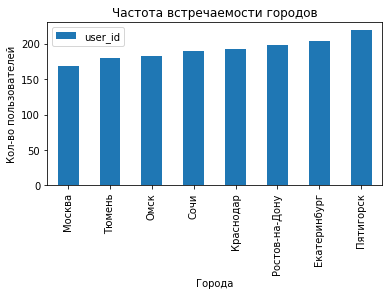

In [16]:
users_city = users.pivot_table(index= 'city', values= 'user_id', aggfunc= 'count').sort_values(by='user_id', ascending = True)
users_city.plot(kind='bar', figsize = (6,3))
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Кол-во пользователей')
plt.show()

In [17]:
users_city.sort_values(by='user_id', ascending = False)

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


Больше всего пользователей сервиса в Пятигорске и Екатеринбурге, меньше всего в Москве. Можно предположить, что это связано с конкуренцией с другими сервисами аренды самокатов: в Пятигорске и Екатеринбурге конкуренция меньше, в Москве - самая большая.

##### Изучим соотношение пользователей с подпиской и без подписки

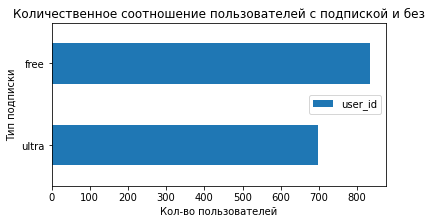

In [55]:
users_subscription = users.pivot_table(index= 'subscription_type', values= 'user_id', aggfunc= 'count').sort_values(by='user_id', ascending = True).reset_index()
users_subscription.plot(kind='barh', figsize = (6,3), x= 'subscription_type')
plt.title('Количественное соотношение пользователей с подпиской и без')
plt.xlabel('Кол-во пользователей')
plt.ylabel('Тип подписки')
plt.show()

In [19]:
users_subscription.sort_values(by='user_id', ascending = False)

,subscription_type,user_id
1,free,835
0,ultra,699


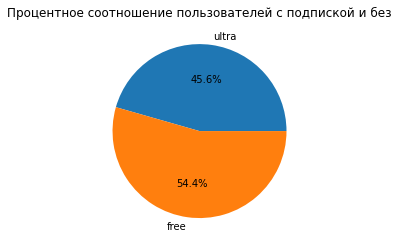

In [20]:
fig, ax = plt.subplots()
ax.pie(users_subscription['user_id'], labels=users_subscription['subscription_type'], autopct='%1.1f%%')
plt.title('Процентное соотношение пользователей с подпиской и без')
plt.show()

Пользователей без подписки больше, чем пользователей с подпиской, на 136 человек, или на 8.8%

##### Изучим возраст пользователей

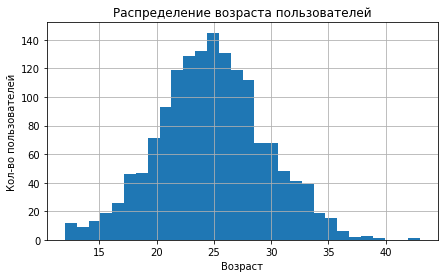

In [21]:
#посмотрим как распределены пользователи по возрасту
users['age'].plot(kind='hist', figsize = (7,4), bins= 30, grid=True)
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Кол-во пользователей')
plt.show()

In [22]:
#посмотрим описание столбца 'age'
users['age'].describe()

count   1534.00
mean      24.90
std        4.57
min       12.00
25%       22.00
50%       25.00
75%       28.00
max       43.00
Name: age, dtype: float64

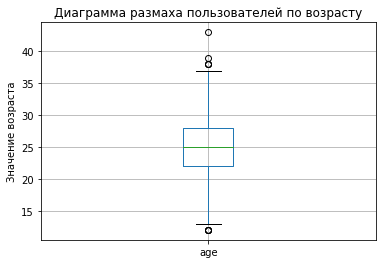

In [23]:
users.boxplot('age')
plt.title('Диаграмма размаха пользователей по возрасту')
plt.ylabel('Значение возраста')
plt.show()

Данные распределены нормально, медиана и среднее почти совпадают. Самым младшим пользователям по 12 лет, самому старшему - 43 года, и согласно диаграмме размаха мы можем считать эти значения редкими.

##### Исследуем расстояние, которое пользователь преодолел за одну поездку

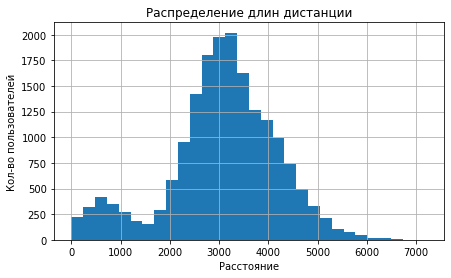

In [24]:
rides['distance'].plot(kind='hist', figsize = (7,4), bins= 30, grid=True)
plt.title('Распределение длин дистанции')
plt.xlabel('Расстояние')
plt.ylabel('Кол-во пользователей')
plt.show()

In [25]:
rides['distance'].describe()

count   18068.00
mean     3070.66
std      1116.83
min         0.86
25%      2543.23
50%      3133.61
75%      3776.22
max      7211.01
Name: distance, dtype: float64

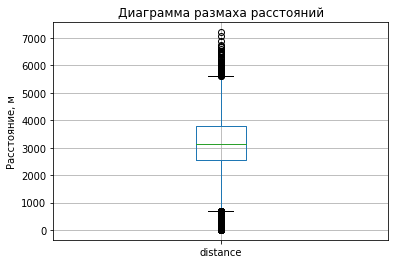

In [26]:
rides.boxplot('distance')
plt.title('Диаграмма размаха расстояний')
plt.ylabel('Расстояние, м')
plt.show()

Самое популярное расстояние для передвижения на самокате у пользователей - чуть больше 3 км. Такое расстояние иногда затруднительно пройти пешком, а на самокате оптимально. На расстояние 3,5 км и более уже не так удобно брать самокат. Самыми редкими являются поездки до 1 км и свыше 5.5 км.

##### Изучим продолжительность поездок

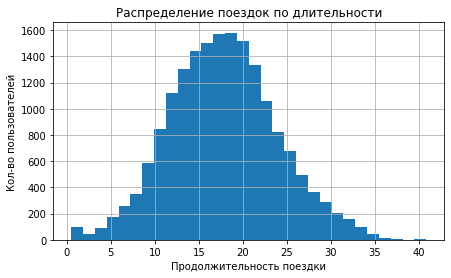

In [27]:
rides['duration'].plot(kind='hist', figsize = (7,4), bins= 30, grid=True)
plt.title('Распределение поездок по длительности')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Кол-во пользователей')
plt.show()

In [28]:
rides['duration'].describe()

count   18068.00
mean       17.81
std         6.09
min         0.50
25%        13.60
50%        17.68
75%        21.72
max        40.82
Name: duration, dtype: float64

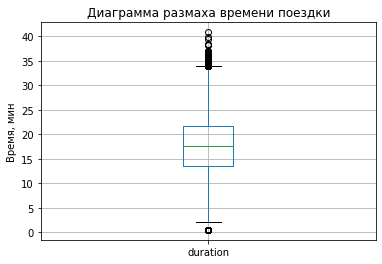

In [29]:
rides.boxplot('duration')
plt.title('Диаграмма размаха времени поездки')
plt.ylabel('Время, мин')
plt.show()

Длительность поездок нормально распределена, среднее значение примерно равно медиане, и находятся они в самом часто встречающемся интервале длительности поездок от 17 до 18 минут. Наибольшая часть всех поездок - это поездки от 14 до 22 минут, самые редкие поездки: до 1 минуты и свыше 34 минут.

**Вывод:** На этом шаге мы изучили 
- Сколько пользователей сервиса в каждом городе, и что чаще всего сервисом пользуются в Пятигорске, а реже всего в Москве, и связано это может быть с разным уровнем конкуренции сервисов аренды самокатов;
- Пользователей с подпиской в сервисе меньше, чем без подписки;
- Средний возраст пользователей сервиса - 25 лет, самым младшим пользователям по 12 лет, самому старшему - 43 года;
- Самое популярное расстояние для передвижения на самокате у пользователей - чуть больше 3 км, оптимально для поездки на самокате;
- Самый популярный интервал длительности поездок - от 17 до 18 минут;
- Если соотнести между собой популярные расстояние и длительность поездки, мы увидим, что полученные данные выглядят правдоподобно.

#### Шаг 4. Объединение данных

In [30]:
#выведем размерности имеющихся датафреймов
print('Количество строк в таблице \'users\':', len(users))
print('Количество строк в таблице \'rides\':', len(rides))
print('Количество строк в таблице \'subscriptions\':', len(subscriptions))

Количество строк в таблице 'users': 1534
Количество строк в таблице 'rides': 18068
Количество строк в таблице 'subscriptions': 2


##### Объединим данные о пользователях, поездках и подписках в один датафрейм

In [31]:
#подсоединим датафрейм Пользователи к датафрейму Поездки по столбцу 'user_id'
total = rides.merge(users, on= 'user_id', how= 'left')

#к уже объединенным двум датафреймам подключим Подписки по столбцу 'subscription_type'
total = total.merge(subscriptions, on= 'subscription_type', how= 'left')

#проверим результат
total.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,25.60,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,15.82,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,6.23,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,18.51,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,26.27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [32]:
#проверим размерность получившегося датафрейма
print('Количество строк в таблице \'total\':', len(total))

Количество строк в таблице 'total': 18068


Делаем вывод, что объединение датафреймов прошло успешно.

##### Создадим ещё два датафрейма из датафрейма ```total```, созданного на этапе 4.1

###### c данными о пользователях без подписки:

In [33]:
total_free = total[total['subscription_type'] == 'free']
print('Кол-во строк:', len(total_free))
total_free.head()

Кол-во строк: 11568


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.69,14.94,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.93,16.23,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.43,20.02,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.91,9.78,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.38,17.43,2021-02-14,2,Айдар,22,Омск,free,8,50,0


###### с данными о пользователях с подпиской:

In [34]:
total_ultra = total[total['subscription_type'] == 'ultra']
print('Кол-во строк:', len(total_ultra))
total_ultra.head()

Кол-во строк: 6500


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,25.60,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,15.82,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,6.23,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,18.51,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,26.27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

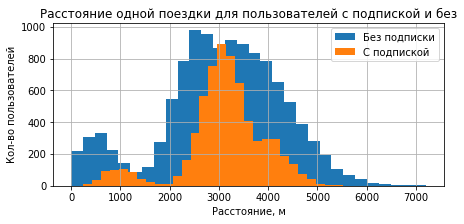

In [35]:
ax = total_free['distance'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30, label='Без подписки')
ax = total_ultra['distance'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30, label='C подпиской')
plt.title('Расстояние одной поездки для пользователей с подпиской и без')
plt.xlabel('Расстояние, м')
plt.ylabel('Кол-во пользователей')
plt.legend(loc='upper right')
plt.show()

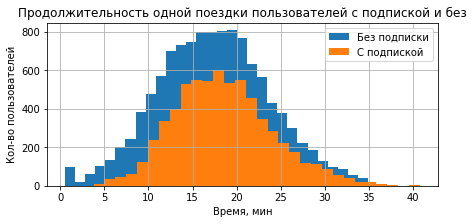

In [36]:
total_free['duration'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30, label='Без подписки')
total_ultra['duration'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 30, label='С подпиской')
plt.title('Продолжительность одной поездки пользователей с подпиской и без')
plt.xlabel('Время, мин')
plt.ylabel('Кол-во пользователей')
plt.legend(loc='upper right')
plt.show()

По распределениям на полученных гистограммах может показаться, что у пользователей без подписки расстояние и продолжительность одной поездки больше. Но так как у нас почти в два раза пользователей без подписки больше, на всякий случай сравним средние значения.

In [37]:
total_vs = total.pivot_table(index='subscription_type', values=['distance', 'duration'], aggfunc= 'mean')
total_vs.columns = ['Среднее расстояние', 'Средняя продолжительность']
total_vs

,Среднее расстояние,Средняя продолжительность
subscription_type,,
free,3045.50,17.39
ultra,3115.45,18.54


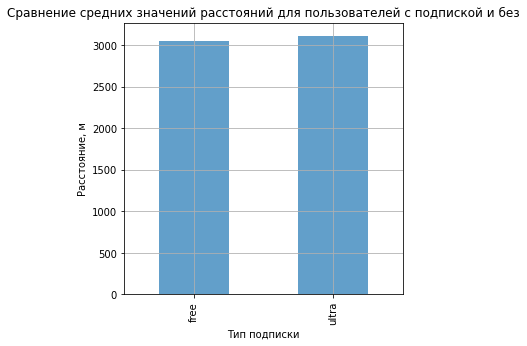

In [38]:
total_vs.plot(kind='bar', y= 'Среднее расстояние', figsize=(5, 5), grid=True, title= 'Сравнение средних значений расстояний для пользователей с подпиской и без', legend=False, alpha=0.7)
plt.ylabel('Расстояние, м')
plt.xlabel('Тип подписки')
plt.show()

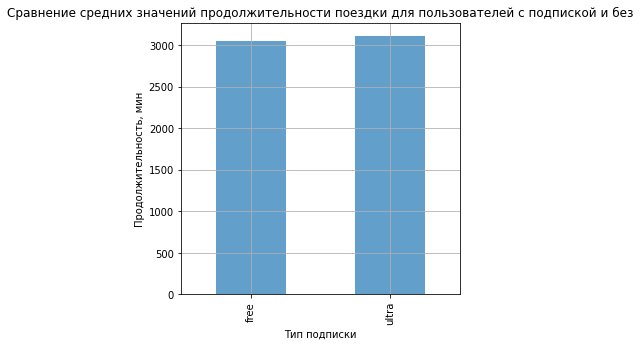

In [39]:
total_vs.plot(kind='bar', y= 'Среднее расстояние', figsize=(5, 5), grid=True, title= 'Сравнение средних значений продолжительности поездки для пользователей с подпиской и без', legend=False, alpha=0.7)
plt.ylabel('Продолжительность, мин')
plt.xlabel('Тип подписки')
plt.show()

**Вывод:**\
На данном этапе мы объединили все три имеющиеся датафрейма с информацией о пользователях, поездках и подписках в один - ```total```, а из него вычленили информацию в два других датафрейма: с данными о пользователях с подпиской (``` total_ultra```) и без (```total_free```).

После этого мы визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий: пользователей без подписки больше, но в среднем они совершают поездки короче по времени и дистанции, чем пользователи с подпиской.

#### Шаг 5. Подсчёт выручки

##### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4

In [40]:
#округлим каждое значение из столбца duration 
total['duration'] = np.ceil(total['duration']).astype('int')

#проверим результат
total.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [41]:
total_agg = total.pivot_table(index= ['user_id', 'month'], values= ['distance', 'duration'], aggfunc= ['count','sum'])
total_agg.drop(total_agg.columns[[1]], axis = 1, inplace=True)
total_agg.columns = ['count_distance', 'sum_distance', 'sum_duration']
total_agg = total_agg.reset_index()
total_agg.head(10)

,user_id,month,count_distance,sum_distance,sum_duration
0,1,1,2,7027.51,42
1,1,4,1,754.16,7
2,1,8,2,6723.47,46
3,1,10,2,5809.91,32
4,1,11,3,7003.50,56
5,1,12,2,6751.63,28
6,2,3,3,10187.72,63
7,2,4,2,6164.38,40
8,2,6,1,3255.34,14
9,2,7,2,6780.72,48


##### Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [42]:
#присоединим таблицы с Пользователями и Подписками к агрегированному датафрейму, чтобы провести расчеты
total_agg = total_agg.merge(users, how='left', on='user_id')
total_agg = total_agg.merge(subscriptions, how = 'left', on='subscription_type')

#проверим результат
total_agg.head()

,user_id,month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.51,42,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.16,7,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.47,46,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.91,32,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.50,56,Кира,22,Тюмень,ultra,6,0,199


In [43]:
#проведем расчет
total_agg['month_profit'] = total_agg['start_ride_price'] * total_agg['count_distance'] + total_agg['minute_price'] * total_agg['sum_duration'] + total_agg['subscription_fee']

#проверим результат
total_agg.head()

,user_id,month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,month_profit
0,1,1,2,7027.51,42,Кира,22,Тюмень,ultra,6,0,199,451
1,1,4,1,754.16,7,Кира,22,Тюмень,ultra,6,0,199,241
2,1,8,2,6723.47,46,Кира,22,Тюмень,ultra,6,0,199,475
3,1,10,2,5809.91,32,Кира,22,Тюмень,ultra,6,0,199,391
4,1,11,3,7003.50,56,Кира,22,Тюмень,ultra,6,0,199,535


**Вывод:**\
На этом этапе была подсчитана помесячная выручка от каждого пользователя. Для этого мы создали датафрейм с агрегированными данными о поездках (```total_agg```) на основе датафрейма с объединёнными данными из предыдущего этапа (```total```). Затем добавили в него столбцы из датафреймов ```users``` и ```subscriptions```, провели расчет и записали его в новый столбец - ```month_profit```.

#### Шаг 6. Проверка гипотез

##### Проверим, тратят ли пользователи с подпиской больше времени на поездки

- Нулевая гипотеза: пользователи с подпиской и без тратят одинаковое время на поездки. 
- Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. 

Для исследования мы имеем два массива данных о продолжительности каждой сессии - отдельно для подписчиков и тех, у кого нет подписки.

In [44]:
alpha = 0.05 #уровень статистической значимости

results = st.ttest_ind(total_ultra['duration'], total_free['duration'], alternative='greater')
print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Вывод:** Проверка гипотезы подтвердила расчет средних значений, который мы делали в пункте 4.3:

In [45]:
total_vs

,Среднее расстояние,Средняя продолжительность
subscription_type,,
free,3045.50,17.39
ultra,3115.45,18.54


Действительно можно сказать о том, что пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.

##### Проверим, превышает ли дистанцию в 3130 метров среднее расстояние, которое проезжают пользователи с подпиской за одну поездку

- Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше либо равно 3130 м.
- Альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 м.

In [46]:
alpha = 0.05 

value = 3130
results = st.ttest_1samp(total_ultra['distance'], value, alternative='greater')
print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 0.9195368847849785
Не отвергаем нулевую гипотезу


**Вывод:** Проверка гипотез говорит о том, что мы можем согласиться с тем, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м. Если ориентироваться на среднее значение расстояний, приведенное в таблице:

In [47]:
total_vs

,Среднее расстояние,Средняя продолжительность
subscription_type,,
free,3045.50,17.39
ultra,3115.45,18.54


мы видим, что оно составляет 3115.45 м, что действительно меньше 3130 м.

##### Проверим, будет ли помесячная выручка от пользователей с подпиской выше, чем  от пользователей без подписки

- Нулевая гипотеза: помесячная выручка от пользователей с подпиской равна помесячной выручке от пользователей без подписки.
- Альтернативная гипотеза: помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

In [48]:
#создадим два новых датафрейма с рассчитанной выручкой по категориям подписок
total_agg_ultra = total_agg[total_agg['subscription_type'] == 'ultra']
total_agg_free = total_agg[total_agg['subscription_type'] == 'free']

In [49]:
alpha = 0.05 

results = st.ttest_ind(total_agg_ultra['month_profit'], total_agg_free['month_profit'], alternative='greater')
print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [50]:
#проверим средними значениями
print('Средняя помесячная выручка от пользователей с подпиской:', round(total_agg_ultra['month_profit'].mean(),2))
print('Средняя помесячная выручка от пользователей без подписки:', round(total_agg_free['month_profit'].mean(),2))

Средняя помесячная выручка от пользователей с подпиской: 362.79
Средняя помесячная выручка от пользователей без подписки: 328.64


**Вывод:** По результатам данного теста и подсчета средних значений есть основания говорить, что помесячная выручка от пользователей с подпиской больше.

##### Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 

Нам дана одна генеральная совокупность, с которой произошли некоторые изменения. В этом случае мы будем проверять, равны ли средние совокупности до и после этого изменения. Так как это гипотеза о равенстве средних для зависимых (парных) выборок, нам понадобится метод ```scipy.stats.ttest_rel()```. В метод мы передаём 2 параметра: набор данных до и после изменения.

#### Шаг 7. Распределения

Отделу маркетинга поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Описанная ситуация подходит по описанию на биномиальное распределение

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


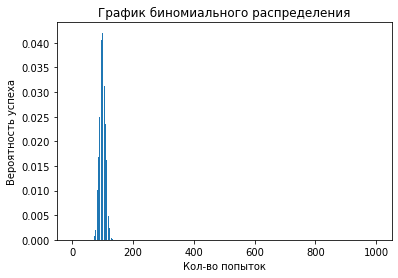

In [51]:
n = 1000 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr)
plt.title('График биномиального распределения')
plt.ylabel('Вероятность успеха')
plt.xlabel('Кол-во попыток')
plt.show()  

Определим ```n```, необходимое для выполнения условия. В диапазоне ```(n - 500, n + 500)``` определим минимальное количество промокодов, чтобы вероятность не выполнить план была не больше 5%.

In [52]:
for n in range (500, 1500):
    if binom.cdf(99, n, p) <= 0.05:
        print("Минимальное кол-во промокодов:", n)
        break

Минимальное кол-во промокодов: 1161


Мы определили тип распределения - биномиальный, построили его график с количеством попыток ```n = 1000```. Затем использовали кумулятивную функцию распределения, чтобы вычислить минимальное количество попыток (= минимальное количество промокодов), чтобы вероятность неудачи была не более 5%. Таким образом, чтобы вероятность не выполнить план была примерно 5 %, нужно разослать минимум 1161 промокод.

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации нужно построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Описанная ситуация подходит по описанию на биномиальное распределение. Аппроксимируем биномиальное распределение нормальным и посчитаем.

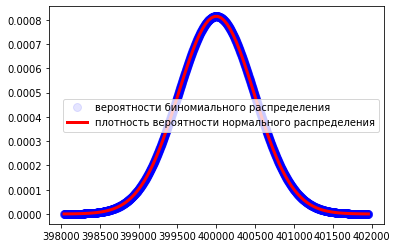

Условие выполняется


In [53]:
#зададим функцию, которая выдаёт num чисел, равномерно распределённых от start до stop
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
#задаём параметры биномиального распределения
n = 1000000
p = 0.4
 
#границы промежутка, в котором будем строить аппроксимацию
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
#зададим набор значений биномиальной величины на выбранном промежутке
x = list(range(max(0, left), right))
 
#рисуем график биномиального распределения
ax = plt.subplot()
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, alpha=0.1,
	      label='вероятности биномиального распределения')
 
#зададим параметры нормального распределения равными мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
#рисуем график нормального распределения:
x = linspace(left, right, 100)
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=1, label='плотность вероятности нормального распределения')
ax.legend(loc='best')
plt.show()
 
#выводим, выполняется ли условие аппроксимации
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

In [54]:
n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))

#задаём нормальное распределение
distr = st.norm(mu, sigma)

x = 399500

result = distr.cdf(x)

print('Вероятность того, что push-уведомления откроют не более 399,5 тыс. пользователей равна',
      round(result, 2))

Вероятность того, что push-уведомления откроют не более 399,5 тыс. пользователей равна 0.15


Мы определили тип распределения - биномиальный. Затем с помощью аппроксимации мы вычислили, что в условиях акции рассылки 1 млн push-уведомлений вероятность того, что откроют их не более 399,5 тыс. пользователей, равна 15%.

# Общий вывод

Целью данного исследования было проанализировать данные о некоторых пользователях популярного сервиса аренды самокатов из нескольких городов, а также об их поездках и проверить несколько гипотез, которые могут помочь бизнесу вырасти.

Первым этапом была выполнена работа по ознакомлению с данными и их предобработке. В работе у нас оказалось три таблицы: с информацией о пользователях, их поездках и подписках.\
Следующим этапом нами был проведен исследовательский анализ данных.\
Нами были сделаны следующие выводы:
- Чаще всего сервисом аренды самокатов пользуются в Пятигорске (219 чел), а реже всего в Москве (168 чел), и связано это может быть с разным уровнем конкуренции сервисов аренды самокатов.
- Пользователей с подпиской в сервисе меньше, чем без подписки: 639 чел против 835 чел.
- Средний возраст пользователей сервиса - 25 лет, самым младшим пользователям по 12 лет, самому старшему - 43 года.
- Самое популярное расстояние для передвижения на самокате у пользователей - чуть больше 3 км, оптимально для поездки на самокате.
- Самый популярный интервал длительности поездок - от 17 до 18 минут.
- Пользователей без подписки больше, но в среднем они совершают поездки короче по времени и дистанции, чем пользователи с подпиской.

Далее нами была подсчитана помесячная выручка от каждого пользователя. После этого мы перешли к проверке гипотез и получили следующие результаты:
- Можно сказать о том, что пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.
- Мы можем согласиться с тем, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м - оптимальное расстояние с точки зрения износа самоката.
- Есть основания говорить, что помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.